# Quantization Aware Training (QAT)

References:

- [Quantization (PyTorch documentation)](https://pytorch.org/docs/stable/quantization.html)
- [`train_quantization.py` (Torchvision reference code)](https://github.com/pytorch/vision/blob/main/references/classification/train_quantization.py)

In [1]:
import os
import sys
from pathlib import Path

import torch
import intel_extension_for_pytorch as ipex
from matplotlib import pyplot as plt
from torch import Tensor
from torch.nn import functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

sys.path.append(os.fspath(Path.cwd().parent.resolve()))

/home/xuanghdu/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
from anime4k_torch.data import NpyDataset, transform_image_train, transform_image_eval
from anime4k_torch.metric import yuv_error
from anime4k_torch.srcnn import SRCNNModel
from anime4k_torch.training import eval_loop, train_loop
from anime4k_torch.visualization import show_images

In [3]:
data_dir = Path("../../data/anime-xuanghdu").resolve()
dataloader_config = {"batch_size": 32, "num_workers": 8, "pin_memory": True}

# resize = (720, 1280)
crop_size = 1080


def transform_train(image) -> Tensor:
    return transform_image_train(image, random_crop_size=crop_size, scale_factor=1)
    # return transform_image_train(image, resize=resize, random_crop_size=crop_size)


def transform_validation(image) -> Tensor:
    return transform_image_eval(image, center_crop_size=crop_size, scale_factor=1)
    # return transform_image_eval(image, resize=resize, center_crop_size=crop_size)


train_set = NpyDataset(data_dir / "train.npy", transform_train)
train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **dataloader_config)

validation_set = NpyDataset(data_dir / "validation.npy", transform_validation)
validation_loader = DataLoader(validation_set, **dataloader_config)

In [4]:
checkpoint_dir = Path("../checkpoints").resolve()
checkpoint_dir.mkdir(exist_ok=True)

Use the "onednn" backend because the default "x86" does not seem to use the full 8 bits ([reference](https://pytorch.org/docs/stable/quantization.html#best-practices)).

Base learning rates: 1e4, 1e-3, 1e-4

| Learning Rates | Validation Losses |   |   |
| -------------- | ----------------- | - | - |
| x1  | 0.00200 | 0.00179 | 0.00147 |
| x4  | 0.00172 | 0.00127 | 0.00122 |
| x8  | 0.00144 | 0.00118 | 0.00115 |
| x10 | 0.00143 | 0.00119 | 0.00115 |
| x16 | 0.00135 | 0.00120 | 0.00114 |
| x20 | 0.00132 | 0.00119 | 0.00114 |

In [5]:
qconfig = torch.ao.quantization.get_default_qat_qconfig("onednn")
model = SRCNNModel(input_depth=3, qconfig=qconfig)
if torch.cuda.is_available():
    device = "cuda"
# Quantization runs extremely slow on macOS.
# elif torch.backends.mps.is_available():
#     device = "mps"
else:
    # device = "cpu"
    device = "xpu"
model.to(device)

model = torch.ao.quantization.prepare_qat(model)
train_losses = []

# Super-convergence with clipping
# optimizer = SGD(model.parameters(), lr=1e1, momentum=0.9, nesterov=True)
# train_losses.extend(
#     train_loop(model, optimizer, yuv_error, train_loader, epochs=1, clip_grad_norm=1e-8)
# )
# validation_loss = eval_loop(model, yuv_error, validation_loader)
# print("Validation loss:", validation_loss)

# Fine tuning with Adam
clip_grad_norm = None
for learning_rate in 1e-2, 1e-3:
    optimizer = Adam(model.parameters(), learning_rate)
    train_losses.extend(
        train_loop(
            model,
            optimizer,
            yuv_error,
            train_loader,
            epochs=1,
            clip_grad_norm=clip_grad_norm,
        )
    )
    validation_loss = eval_loop(model, yuv_error, validation_loader)
    print("Validation loss:", validation_loss)

with torch.inference_mode():
    model.cpu()
    model.eval()
    model = torch.ao.quantization.convert(model)
    torch.save(model.state_dict(), checkpoint_dir / "srcnn_i8.pth")

Evaluation: 100%|██████████| 55/55 [00:31<00:00,  1.75it/s, batch_loss=0.00451]


Validation loss: 0.002705407483145637


Evaluation: 100%|██████████| 55/55 [00:22<00:00,  2.43it/s, batch_loss=0.00164] 

Validation loss: 0.0014212156109575898


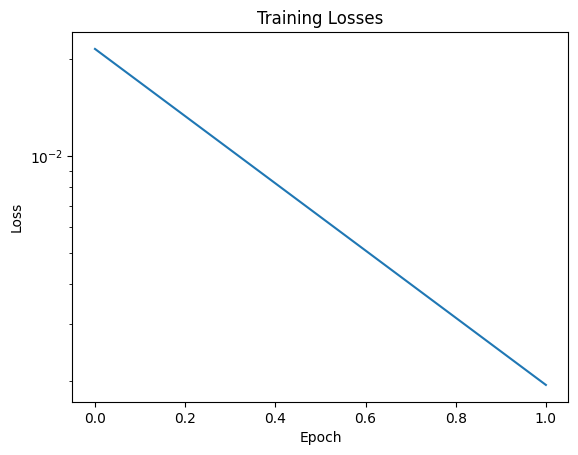

In [6]:
plt.plot(train_losses)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
None  # Suppress output.

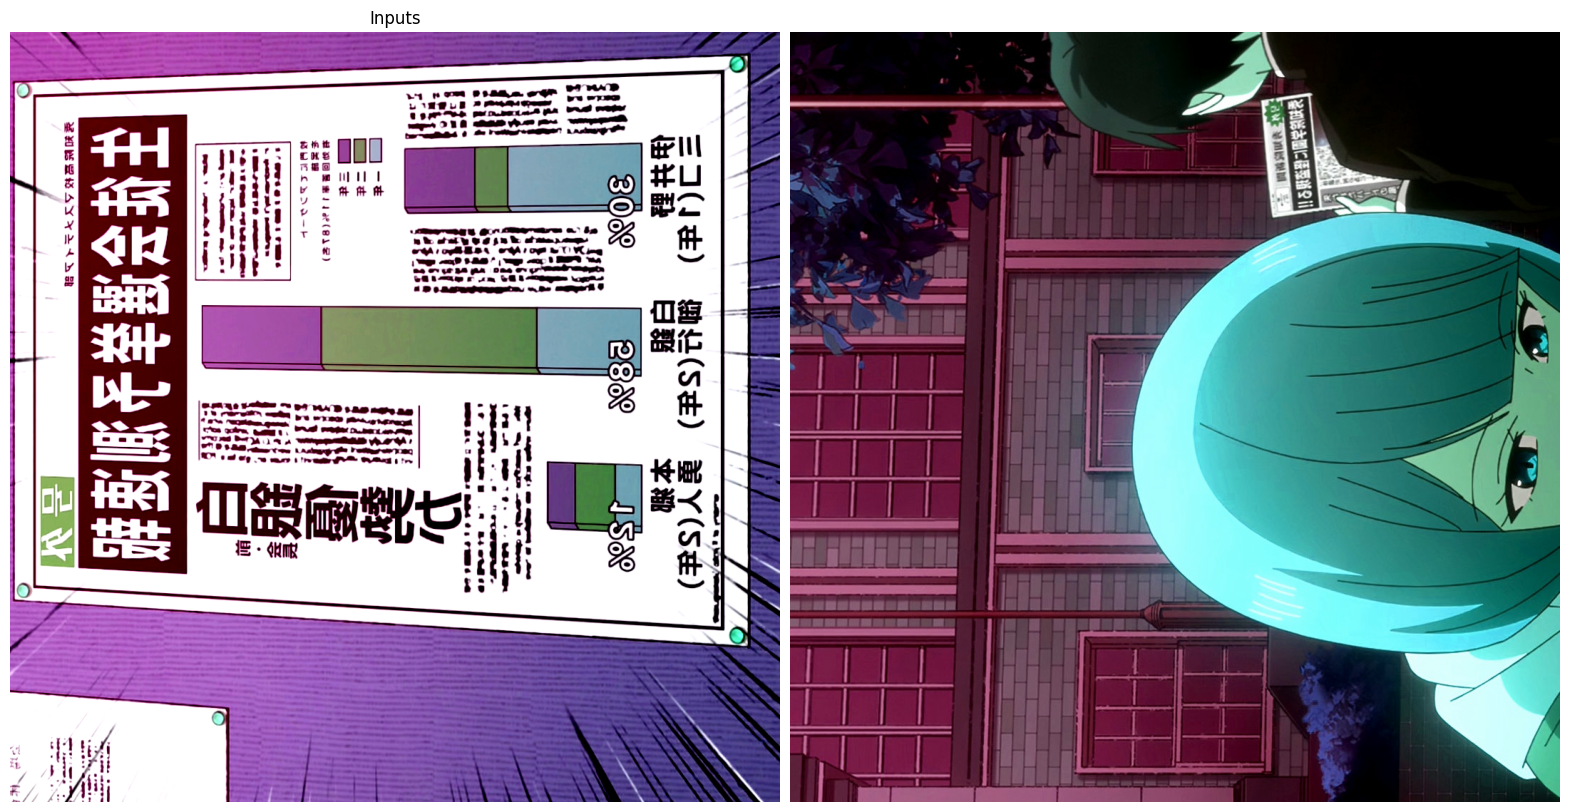

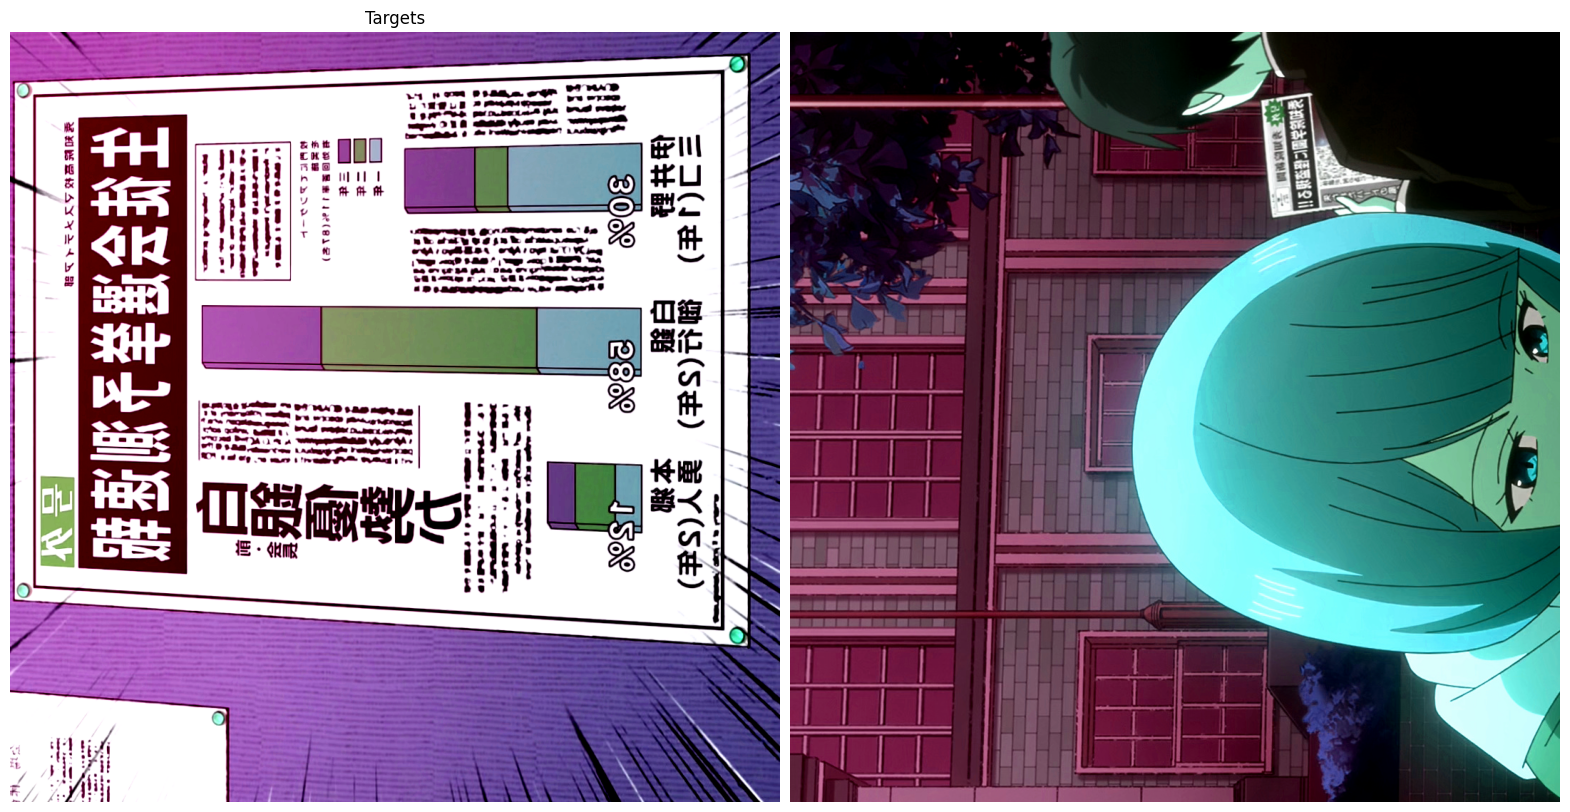

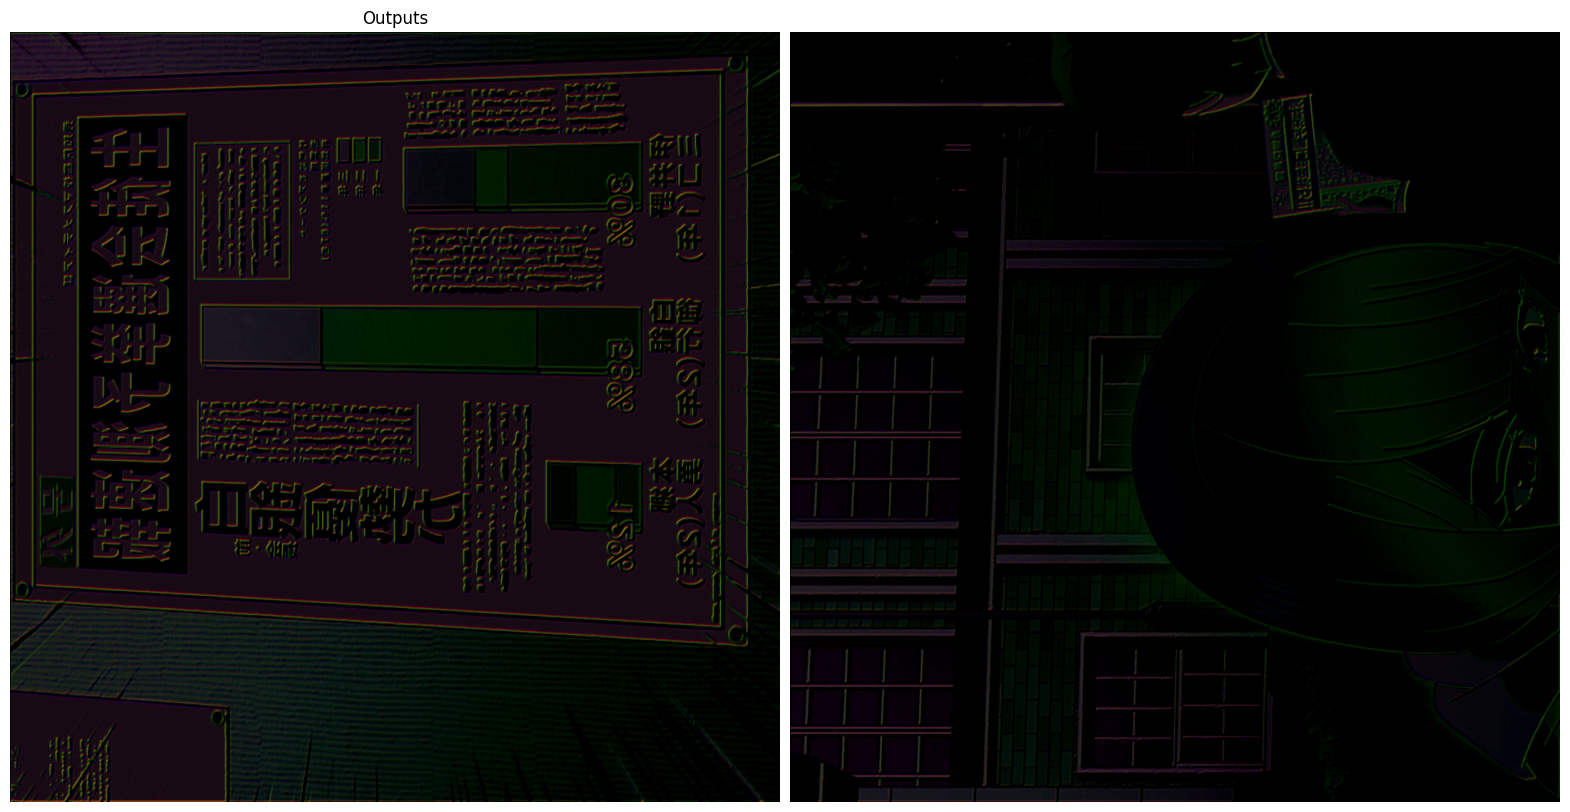

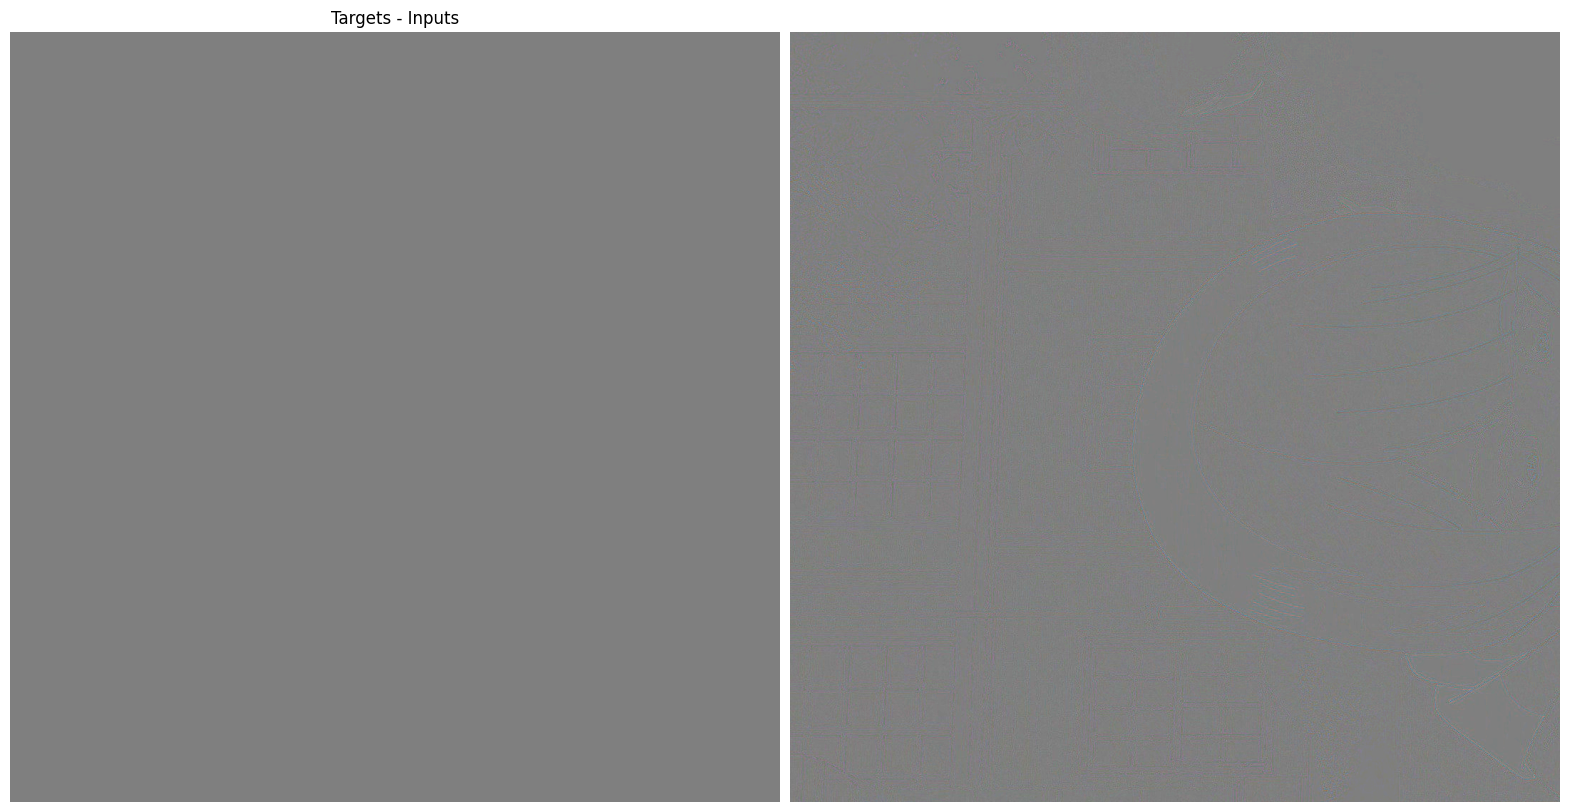

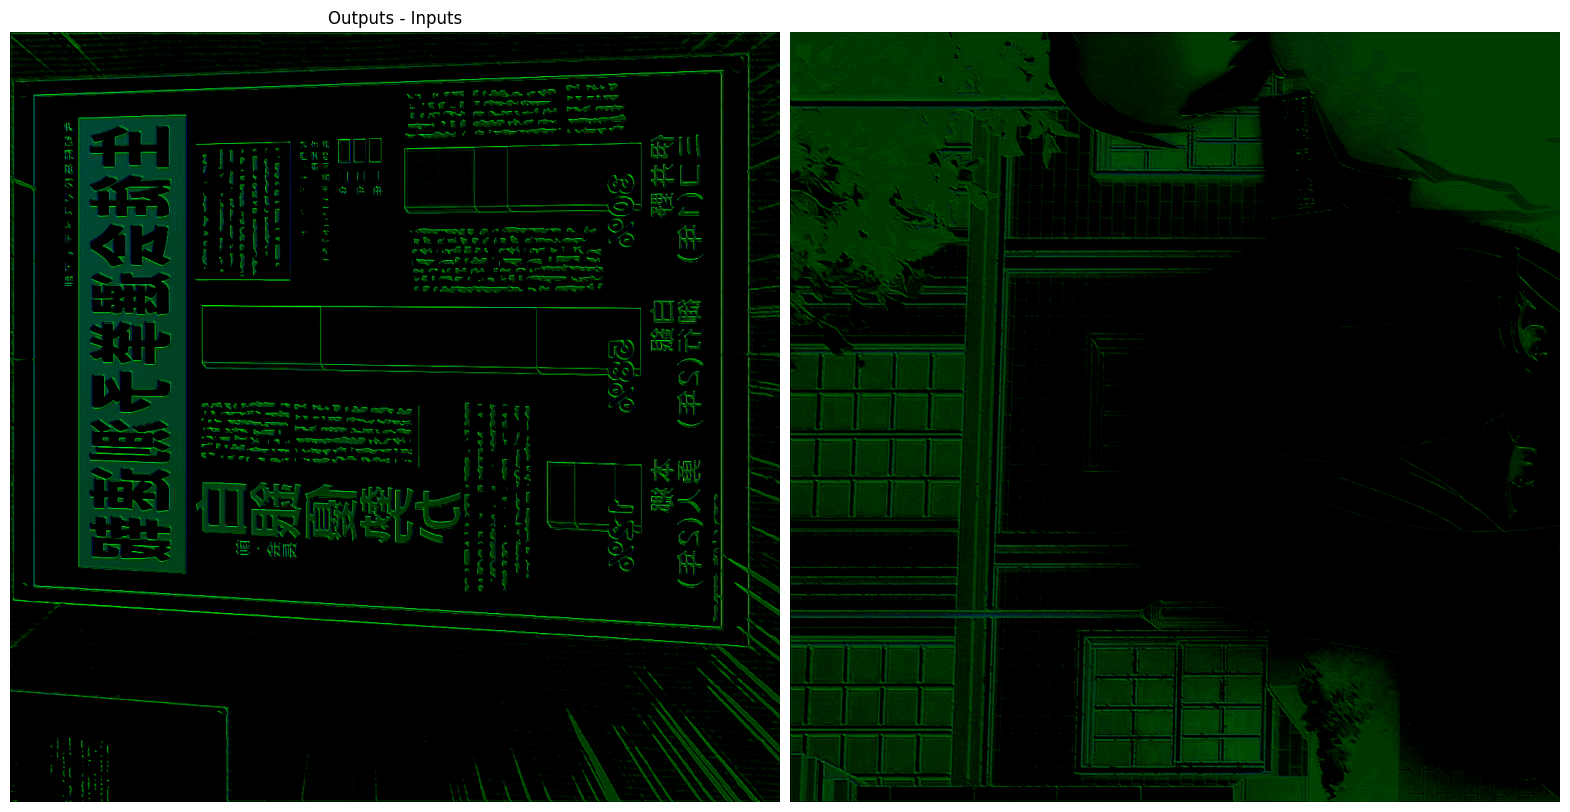

In [12]:
figsize = (20, 20)

with torch.inference_mode():
    inputs, targets = next(iter(DataLoader(train_set, batch_size=2)))
    model.eval()
    outputs = model(inputs)

figure = plt.figure(figsize=figsize)
show_images(figure, inputs)
figure.axes[0].set_title("Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, targets)
figure.axes[0].set_title("Targets")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs)
figure.axes[0].set_title("Outputs")

upsampled_inputs = F.interpolate(inputs, scale_factor=1, mode="bilinear")

figure = plt.figure(figsize=figsize)
show_images(figure, targets - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Targets - Inputs")

figure = plt.figure(figsize=figsize)
show_images(figure, outputs - upsampled_inputs, value_range=(-0.2, 0.2))
figure.axes[0].set_title("Outputs - Inputs")

None  # Suppress output.

In [8]:
print(model)
print(
    "Number of conv parameters:",
    sum(v.numel() for k, v in model.state_dict().items() if k.endswith(".weight")),
)

SRCNNModel(
  (conv_layers): ModuleList(
    (0): QuantizedConv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), scale=0.011276447214186192, zero_point=75, padding=(1, 1))
    (1): QuantizedConv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), scale=0.030941080302000046, zero_point=168, padding=(1, 1))
    (2): QuantizedConv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), scale=0.007981440052390099, zero_point=65, padding=(1, 1))
  )
  (quant): Quantize(scale=tensor([0.0039]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)
Number of conv parameters: 1008
